In [40]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [3]:
torch.cuda.is_available(), torch.backends.cudnn.enabled

(True, True)

In [4]:
PATH = 'data/dogscats'
sz = 224

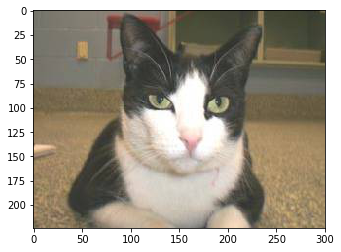

In [5]:
files = os.listdir(f'{PATH}/valid/cats')[:5]
img = plt.imread(f'{PATH}/valid/cats/{files[2]}')
plt.imshow(img)

In [6]:
import inspect
def get_module_path(module):
    return inspect.getmodule(module).__name__ + f'.{module.__name__}'
print(get_module_path(resnet34))
print(get_module_path(ImageClassifierData))
print(get_module_path(tfms_from_model))
print(get_module_path(ConvLearner))

torchvision.models.resnet.resnet34
fastai.dataset.ImageClassifierData
fastai.transforms.tfms_from_model
fastai.conv_learner.ConvLearner


In [7]:
arch = resnet34
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz))
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.01, 2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

[0.      0.04088 0.03442 0.9873 ]
[1.      0.04258 0.03212 0.99023]



In [14]:
log_preds = learn.predict()
preds = np.argmax(log_preds, axis=1)
probs = np.exp(log_preds[:,1])

In [15]:
def rand_by_mask(mask):
    return np.random.choice(np.where(mask)[0], 4, replace=False)

def rand_by_correct(is_correct):
    return rand_by_mask((preds == data.val_y)==is_correct)

In [16]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

In [17]:
def plot_val_with_title(idxs, title):
    imgs = np.stack([data.val_ds[x][0] for x in idxs])
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(data.val_ds.denorm(imgs), rows=1, titles=title_probs)

In [25]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct):
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & \
                         (data.val_y == y), mult)

Most correct cats


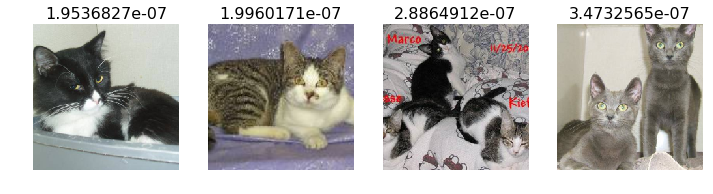

In [28]:
plot_val_with_title(most_by_correct(0, True), 'Most correct cats')

Most correct dogs


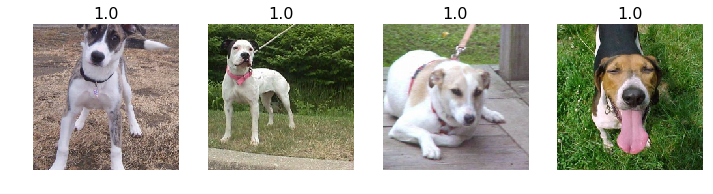

In [30]:
plot_val_with_title(most_by_correct(1, True), 'Most correct dogs')

Most incorrect cats


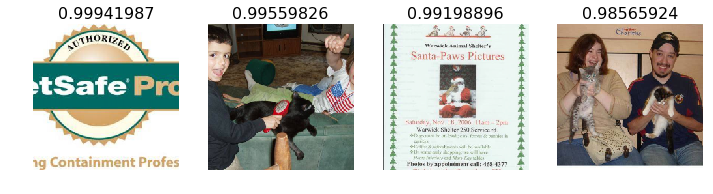

In [31]:
plot_val_with_title(most_by_correct(0, False), 'Most incorrect cats')

Most incorrect dogs


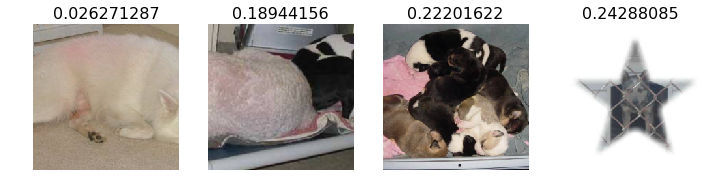

In [33]:
plot_val_with_title(most_by_correct(1, False), 'Most incorrect dogs')

Most uncertain predictions


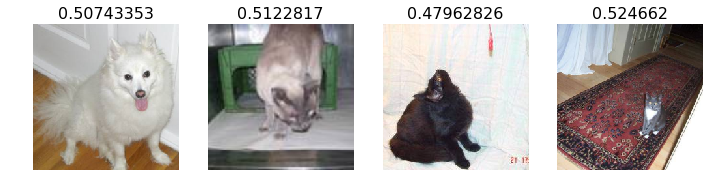

In [34]:
most_uncertain = np.argsort(np.abs(probs-0.5))[:4]
plot_val_with_title(most_uncertain, 'Most uncertain predictions')

## Choosing a learning rate

In [37]:
sns.set()

In [36]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [38]:
lrf = learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 85%|████████▍ | 305/360 [00:02<00:00, 121.78it/s, loss=0.425]


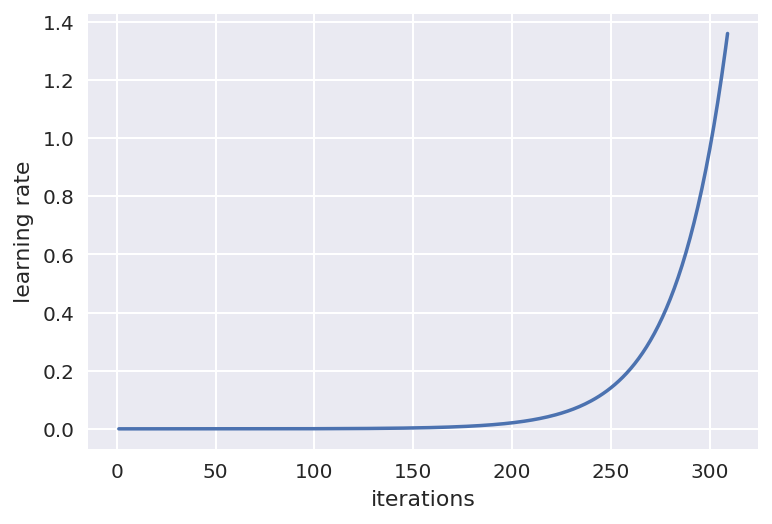

In [41]:
learn.sched.plot_lr()

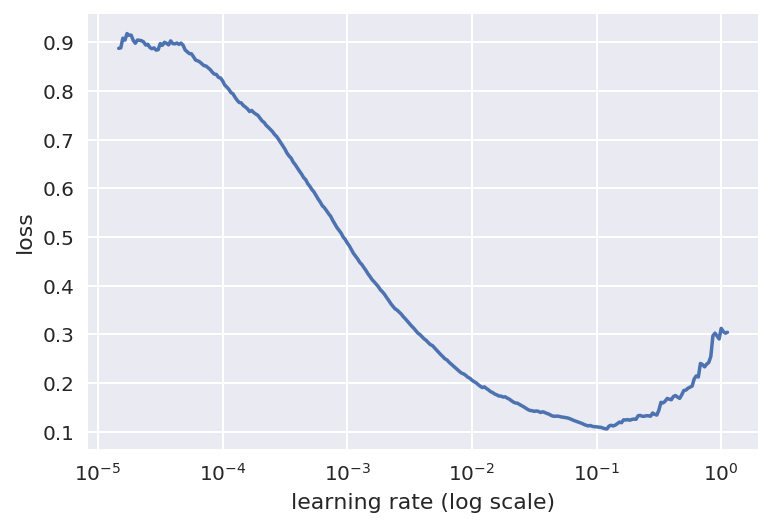

In [42]:
learn.sched.plot()

In [43]:
print(get_module_path(tfms_from_model))

fastai.transforms.tfms_from_model


In [45]:
tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_paths(PATH, tfms=tfms)
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(1e-2, 1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

[0.      0.04795 0.02612 0.99316]



In [47]:
learn.precompute = False

In [48]:
learn.fit(1e-2, 3, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

[0.      0.05002 0.02599 0.98926]
[1.      0.0411  0.02603 0.98926]
[2.      0.04685 0.02596 0.98975]

